#Single-photon Classification

##Toy Example

In [0]:

from google.colab import files
import math
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow.compat.v2.keras as keras
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib import cm

In [0]:
np.set_printoptions(linewidth=200)
rng = np.random.RandomState(seed=2)

NUM_CLASSES = 2
XDIM = 4
XYDIM = 8
# This forces the unitary transformation to be real (orthogonal.)
# This does not affect the maximum achievable performance for this simple
# example.
USE_ORTHOGONAL = True

c0 = np.array([[1, 1, 1, 0], [0, 1, 0, 0]], np.float64)
c1 = np.array([[0, 1, 1, 1], [0, 0, 1, 0]], np.float64)

x_train = np.stack([c0, c1], axis=0)
y_train = np.array([0, 1], np.float64)
x_test = x_train
y_test = y_train


In [0]:
def quantum_states_from_xs(xs):
  amplitudes = np.sqrt(
      xs / np.einsum('byx->b', xs)[:, np.newaxis, np.newaxis])
  return amplitudes.reshape(xs.shape[0], -1)
  
xq_train = quantum_states_from_xs(x_train)
xq_test = quantum_states_from_xs(x_test)

y_train_cat = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_cat = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [0]:
def accuracy_from_samples(samples, labels, decision):
  decision_per_class = keras.utils.to_categorical(decision, NUM_CLASSES)
  labels_per_class = keras.utils.to_categorical(labels, NUM_CLASSES)
  # For every test-set image, we need to find out what fraction of photons
  # would make our classifier predict the category correctly.
  sample_total_photons_yielding_correct_cat = np.einsum(
    'byx,yxc,bc->b', samples, decision_per_class, labels_per_class)
  sample_fraction_photons_yielding_correct_cat = (
    sample_total_photons_yielding_correct_cat / np.einsum('byx->b', samples))
  return sample_fraction_photons_yielding_correct_cat.mean()


In [0]:

# "Classical baseline" performance:
# If a pixel arrives at (row, col), we need to know the most likely digit,
# with probabilities as observed on the training set.
x_train_intensity_per_cat = (
    np.einsum('byx,bc->yxc', x_train, y_train_cat) +
    # Trick: We add a tiny randomized-for-random-tie-breaking 'epsilon'
    # to the brightnesses that only changes results for pixels that were
    # dark in every single training example.
    rng.uniform(low=0, high=1e-100, size=(XYDIM // XDIM, XDIM, NUM_CLASSES)))
x_train_most_likely_pixel_cat = keras.utils.to_categorical(
    x_train_intensity_per_cat.argmax(axis=2))

In [13]:
baseline_accuracy = np.round(accuracy_from_samples(
    x_test, y_test, x_train_intensity_per_cat.argmax(axis=2)), 4)
print('Classical-detection baseline accuracy: %.2f%%' %
      (100 * baseline_accuracy))

Classical-detection baseline accuracy: 75.00%


In [14]:
# For every test-set image, we need to find out what fraction of photons
# would make our classifier predict the category correctly.
x_test_batched_total_photons_yielding_correct_cat = np.einsum(
    'byx,yxc,bc->b', x_test, x_train_most_likely_pixel_cat, y_test_cat)
x_test_fraction_photons_yielding_correct_cat = (
    x_test_batched_total_photons_yielding_correct_cat / np.einsum('byx->b', x_test))
baseline_accuracy = np.round(x_test_fraction_photons_yielding_correct_cat.mean(), 4)
# Baseline accuracy 21.27% is found to be RNG seed independent.
# (Seed influences assignment of dark-everywhere-on-training-set pixels.
# So, apparently, the test-set does not have relevant ink on pixels that are
# dark on the training set.)
print('Classical-detection baseline accuracy: %.2f%%' %
      (100 * baseline_accuracy))


Classical-detection baseline accuracy: 75.00%


In [15]:
k_h0 = tf.keras.backend.variable(
     rng.normal(size=(XYDIM, XYDIM), scale=0.01),
     dtype='float64', name='H0')

x_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

def get_loss_accuracies_p(h0, psi):
  h0_T = tf.transpose(h0)
  mult_imag = 0.0 if USE_ORTHOGONAL else 1.0
  ih = tf.complex(h0 - h0_T, mult_imag * (h0 + h0_T))
  u = tf.linalg.expm(ih)
  rot = tf.math.real(tf.einsum('bp,qp->bq', tf.cast(psi, tf.complex128), u)).numpy()
  u_psi = tf.reshape(
      tf.einsum('bp,qp->bq', tf.cast(psi, tf.complex128), u),
      (-1, NUM_CLASSES, XYDIM // NUM_CLASSES))
      # (NUM_CLASSES, XYDIM // NUM_CLASSES, NUM_CLASSES))
  u_psi_r = tf.math.real(u_psi)
  u_psi_i = tf.math.imag(u_psi)
  probs = tf.einsum('bcs->bc', tf.math.square(u_psi_r) + tf.math.square(u_psi_i))
  loss = x_loss(tf.eye(NUM_CLASSES, dtype=tf.float64), probs)
  batch_quantum_accuracy = tf.linalg.trace(probs) / NUM_CLASSES
  batch_manyphoton_accuracy = tf.math.reduce_mean(
      keras.metrics.categorical_accuracy(
          tf.eye(NUM_CLASSES, dtype=tf.float64), probs))
  return loss, batch_quantum_accuracy, batch_manyphoton_accuracy, u

  
def train_step(optimizer, k_h0, psis):
  c1 = tf.constant(1.0, dtype=tf.float64)
  tape = tf.GradientTape()
  with tape:
    tape.watch(k_h0)
    loss, accuracy_q, accuracy_m, u = get_loss_accuracies_p(k_h0, psis)
  gradients = tape.gradient(loss, [k_h0])
  optimizer.apply_gradients(zip(gradients, [k_h0]))
  return loss, accuracy_q, accuracy_m, u


def get_test_set_accuracies(h0):
  loss, accuracy_q, accuracy_m, u = get_loss_accuracies_p(
      h0, xq_test)
  del loss, u  # Unused.
  return accuracy_q, accuracy_m


def train_a_model(num_steps=50):
  """Trains a model.
  
  Interrupting this function will produce a valid partially-trained model.
  """
  optimizer1 = tf.keras.optimizers.SGD(learning_rate=0.3)
  optimizer2 = tf.keras.optimizers.SGD(learning_rate=0.03)
  for ep in range(num_steps):

    loss, accuracy_q, accuracy_m, u = train_step(
          optimizer1, k_h0, xq_train)
    tr_u = tf.linalg.trace(u)
    if ep % 20 == 0:
      print('DDD-E=%d, loss=%.3f, acc_q=%.3f, acc_m=%.3f, tr_U=%s' %
            (ep, loss.numpy(), accuracy_q.numpy(), accuracy_m.numpy(),
             np.round(tr_u.numpy(), 3)))
      print('Test Set accuracies: %.4f / %.4f' % get_test_set_accuracies(k_h0))
  for ep in range(50):
    loss, accuracy_q, accuracy_m, u = train_step(
          optimizer2, k_h0, xq_train)
    tr_u = tf.linalg.trace(u)
    if ep % 20 == 0:
      print('DDD-E=%d, loss=%.3f, acc_q=%.3f, acc_m=%.3f, tr_U=%s' %
            (ep, loss.numpy(), accuracy_q.numpy(), accuracy_m.numpy(),
            np.round(tr_u.numpy(), 3)))
      print('Test Set accuracies: %.4f / %.4f' % get_test_set_accuracies(k_h0))


train_a_model()


print('Model accuracies: %.4f / %.4f' % get_test_set_accuracies(k_h0))


DDD-E=0, loss=0.867, acc_q=0.491, acc_m=0.500, tr_U=(7.993+0j)
Test Set accuracies: 0.8252 / 1.0000
DDD-E=20, loss=0.069, acc_q=0.933, acc_m=1.000, tr_U=(6.816+0j)
Test Set accuracies: 0.9330 / 1.0000
DDD-E=40, loss=0.069, acc_q=0.933, acc_m=1.000, tr_U=(6.816+0j)
Test Set accuracies: 0.9330 / 1.0000
DDD-E=0, loss=0.069, acc_q=0.933, acc_m=1.000, tr_U=(6.816+0j)
Test Set accuracies: 0.9330 / 1.0000
DDD-E=20, loss=0.069, acc_q=0.933, acc_m=1.000, tr_U=(6.816+0j)
Test Set accuracies: 0.9330 / 1.0000
DDD-E=40, loss=0.069, acc_q=0.933, acc_m=1.000, tr_U=(6.816+0j)
Test Set accuracies: 0.9330 / 1.0000
Model accuracies: 0.9330 / 1.0000


In [0]:
def PlotSamples(samples, filename, xlabel=None, image_labels=None, figsize=(4, 2)):
  fig, axs = plt.subplots(1, 2, figsize=figsize)
  norm = cm.colors.Normalize(vmax=0.8, vmin=0) # Boost a bit brightness to get clearer images.
  font0 = FontProperties()
  font1 = font0.copy()
  font1.set_size('xx-small')
  for i, ax in enumerate(axs):
    ax.imshow(samples[i, :, :], cmap=plt.get_cmap('gray'), norm=norm, interpolation='nearest')
    if image_labels is not None:
      labels = image_labels[i, :, :]
      n, m = labels.shape
      for ii in range(0, n):
        for jj in range(0, m):
          if labels[ii, jj]:
            ax.text(jj, ii, labels[ii, jj],
                    horizontalalignment='center',
                    verticalalignment='center')
    ax.set_title('c = %d' % i)
    ax.grid(True)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
  if xlabel:
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='red', top='off', bottom='off', left='off', right='off')
    plt.grid(False)
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    plt.xlabel(xlabel)
    plt.gca().xaxis.set_label_coords(0.5, 0)
  plt.savefig(filename, bbox_inches='tight')
  files.download(filename)

In [0]:
def get_transformed_images(psi, h0=None, u=None):
  if h0 is not None:
    h0_T = tf.transpose(h0)
    ih = tf.complex(h0 - h0_T, h0 + h0_T)
    u = tf.linalg.expm(ih)
  u_psi = tf.reshape(
      tf.einsum('cp,qp->cq', tf.cast(psi, tf.complex128), u),
      (NUM_CLASSES, XYDIM // XDIM, XDIM))
  u_psi_r = tf.math.real(u_psi)
  u_psi_i = tf.math.imag(u_psi)
  return tf.math.square(u_psi_r) + tf.math.square(u_psi_i)



In [0]:
# The simple suboptimal transformation presented in the paper.

i4 = np.eye(XDIM, dtype=np.complex128)
u_toy = math.sqrt(1 / 2.) * np.concatenate(
    (np.concatenate((-i4, i4), axis=1),
     np.concatenate((i4, i4), axis=1)), axis=0)


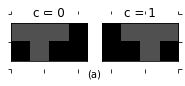

In [19]:
# The probability amplitude for the two symbols of the toy example.

xq_train_initial = get_transformed_images(xq_train, u=np.eye(XYDIM))
PlotSamples(xq_train_initial, 'toy_samples.png', xlabel='(a)', figsize=(3, 1))

In [20]:
# The probability amplitude for the optimal (learnt) transformation. This is not
# included in the paper for lack of space.

t_xq_train_optimal = get_transformed_images(xq_train, h0=k_h0).numpy()
PlotSamples(t_xq_train_optimal, 'toy_projected_optimal.png', '(c)', figsize=(3, 1))

In [0]:
# Accuracy for the optimal transformation.

optimal_accuracy = np.round(accuracy_from_samples(
    t_xq_train_optimal, y_train, t_xq_train_optimal.argmax(axis=0)), 4)
print('Optimal accuracy: %.2f%%' % (100 * optimal_accuracy))

Optimal accuracy: 93.25%


In [27]:
# The proability amplitude for the suboptimal transformation presented in the
# paper.

t_xq_train_toy = get_transformed_images(xq_train, u=u_toy)
PlotSamples(t_xq_train_toy, 'toy_projected_simple.png', '(b)', figsize=(3, 1))

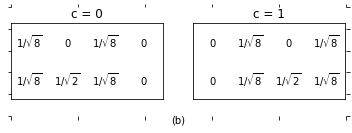

In [28]:
# The values of the probability amplitude for the suboptimal transformation.

frac_8 = '$1/\sqrt{8}$'
frac_2 = '$1/\sqrt{2}$'
labels = np.array([[[frac_8, '$0$', frac_8, '$0$'], [frac_8, frac_2, frac_8, '$0$']],
                   [['$0$', frac_8, '$0$', frac_8], ['$0$', frac_8, frac_2, frac_8]]])
PlotSamples(np.ones((2, 2, 4)), 'toy_projected_values_simple.png', '(b)', image_labels=labels, figsize=(6, 2))

In [29]:
toy_accuracy = np.round(accuracy_from_samples(
    t_xq_train_toy, y_train, np.argmax(t_xq_train_toy, axis=0)), 4)
print('Toy example accuracy: %.2f%%' % (100 * toy_accuracy))

Toy example accuracy: 87.50%


Max accuracy computed analytically is the following:

$a_M=(\sqrt{1-\cos^2\alpha} + 1)/2$

In [31]:
cos_a = np.dot(xq_train[0], xq_train[1])
max_accuracy = (np.sqrt(1 - cos_a ** 2) + 1) / 2
print('Max possible accuracy %.2f%%' % (100 * max_accuracy))

Max possible accuracy 93.30%
